Student: Dorin Doncenco

Use the binarized MNIST database to:

·        Generate images with autoregressive models available in the pytorch library

·        What are the encountered difficulties (initialization…)

·        Comment on the obtained results according to the used settings 


In [1]:
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F
#l1 loss acts as (is) our reconstruction loss
from torch.nn import L1Loss
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib
import math


import dataset_loader

%matplotlib inline

mnist_path = "./mnist.pkl.gz"

# the dataset contains 3 splits (train/dev/test),
# each one containing two vectors (pixels and classes)
(train_data_pixels, train_data_classes), \
(dev_data_pixels, dev_data_classes), _ = dataset_loader.load_mnist(mnist_path)

#convert data to pytorch tensors
train_data_pixels = torch.from_numpy(train_data_pixels)
train_data_classes = torch.from_numpy(train_data_classes)
dev_data_pixels = torch.from_numpy(dev_data_pixels)
dev_data_classes = torch.from_numpy(dev_data_classes)

In [2]:
# rnn classifier
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        # Forward propagate LSTM
        out, _ = self.rnn(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [3]:
# set hyper
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 1
learning_rate = 0.001


In [4]:
#train rnn
rnn = RNNClassifier(input_size, hidden_size, num_classes, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)


In [5]:
# Train the model
total_step = len(train_data_pixels) // batch_size
for epoch in range(num_epochs):
    for i in range(total_step):
        #get batch
        batch_x = train_data_pixels[i*batch_size:(i+1)*batch_size].view(-1, 28, 28)
        batch_y = train_data_classes[i*batch_size:(i+1)*batch_size]
        
        # Forward pass
        outputs = rnn(batch_x.float())
        loss = criterion(outputs, batch_y)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/1], Step [100/500], Loss: 1.1534
Epoch [1/1], Step [200/500], Loss: 0.8416
Epoch [1/1], Step [300/500], Loss: 0.5088
Epoch [1/1], Step [400/500], Loss: 0.4847
Epoch [1/1], Step [500/500], Loss: 0.5786


In [6]:
#make an RNN mnist generator
class RNNGenerator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNNGenerator, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        # Forward propagate LSTM
        out, _ = self.rnn(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out)
        return out

In [85]:
#hyperparams
input_size = 28
hidden_size = 128
num_layers = 5
num_classes = 28
batch_size = 100
num_epochs = 5
learning_rate = 0.001


In [86]:
#train rnn
rnn = RNNGenerator(input_size, hidden_size, num_classes, num_layers)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

In [87]:
# Train the model
total_step = len(train_data_pixels) // batch_size
for epoch in range(num_epochs):
    for i in range(total_step):
        #get batch: x is random noise, y is target image
        batch_x = torch.rand(batch_size, 28, 28)
        batch_y = train_data_pixels[i*batch_size:(i+1)*batch_size].view(-1, 28, 28)
        
        # Forward pass
        outputs = rnn(batch_x.float())
        loss = criterion(outputs, batch_y)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [100/500], Loss: 0.1354
Epoch [1/5], Step [200/500], Loss: 0.1340
Epoch [1/5], Step [300/500], Loss: 0.1291
Epoch [1/5], Step [400/500], Loss: 0.1313
Epoch [1/5], Step [500/500], Loss: 0.1288
Epoch [2/5], Step [100/500], Loss: 0.1325
Epoch [2/5], Step [200/500], Loss: 0.1282
Epoch [2/5], Step [300/500], Loss: 0.1233
Epoch [2/5], Step [400/500], Loss: 0.1281
Epoch [2/5], Step [500/500], Loss: 0.1260
Epoch [3/5], Step [100/500], Loss: 0.1304
Epoch [3/5], Step [200/500], Loss: 0.1252
Epoch [3/5], Step [300/500], Loss: 0.1225
Epoch [3/5], Step [400/500], Loss: 0.1278
Epoch [3/5], Step [500/500], Loss: 0.1259
Epoch [4/5], Step [100/500], Loss: 0.1300
Epoch [4/5], Step [200/500], Loss: 0.1245
Epoch [4/5], Step [300/500], Loss: 0.1220
Epoch [4/5], Step [400/500], Loss: 0.1277
Epoch [4/5], Step [500/500], Loss: 0.1259
Epoch [5/5], Step [100/500], Loss: 0.1300
Epoch [5/5], Step [200/500], Loss: 0.1240
Epoch [5/5], Step [300/500], Loss: 0.1222
Epoch [5/5], Step [400/500], Loss:

In [88]:
# generate samples
num_samples = 10
samples = torch.zeros(num_samples, 28, 28)

#get batch of random noise
batch_x = torch.rand(10, 28, 28)

# Forward pass
outputs = rnn(batch_x.float())
samples = outputs


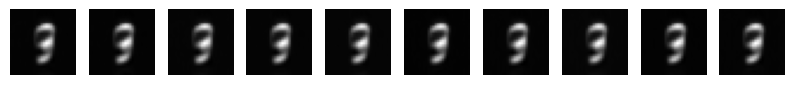

In [89]:
# plot samples
fig = plt.figure(figsize=(10, 10))
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(samples[i].detach().numpy(), cmap='gray')
    plt.axis('off')

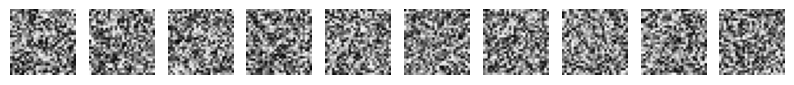

In [90]:
#plot batch_x
fig = plt.figure(figsize=(10, 10))
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(batch_x[i].detach().numpy(), cmap='gray')
    plt.axis('off')